In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

import glob
import imageio
import os
import PIL
import time
import tqdm

from IPython import display

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [6]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(4))

    return model

In [7]:
encoder = make_encoder_model()
distribution = encoder(train_images[0].astype('float32').reshape(1,28,28,1))
print(distribution)

tf.Tensor([[-0.1140316   0.14290488 -0.06722414  0.15178873]], shape=(1, 4), dtype=float32)


In [8]:
def make_decoder_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, use_bias=True, input_shape=(2,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())    
    
    model.add(layers.Dense(7*7*32, use_bias=True))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 32)))
    assert model.output_shape == (None, 7, 7, 32)

    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

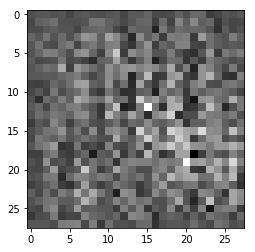

In [9]:
decoder = make_decoder_model()
generated_image = decoder(distribution[0,:2] + tf.random.normal((1,2))*distribution[0,2:], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [10]:
arr = np.arange(-5,5.1,1)
values = []
for i in range(121):
    values.append([arr[i%11],arr[i//11]])
num_grid = np.array(values).astype('float32')

In [11]:
def generate_and_save_images(model, arr_numbers, epoch):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = decoder(arr_numbers, training=False)

    fig = plt.figure(figsize=(11,11))

    for i in range(predictions.shape[0]):
        plt.subplot(11, 11, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('VAE_images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

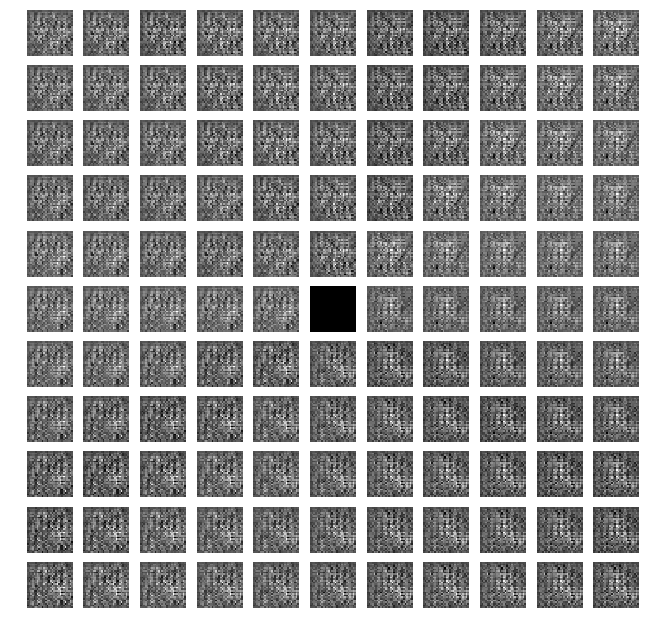

In [12]:
generate_and_save_images(decoder, num_grid, 0)

In [13]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [14]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

In [15]:
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        generated_samples = encoder(images, training=True)
        mean = generated_samples[:,:2]
        logvar = generated_samples[:,2:]
        sample_feed = tf.random.normal(shape = mean.shape) * tf.exp(logvar * .5) + mean
        output_images = decoder(sample_feed)

        loss1 = tf.reduce_sum(tf.square(images-output_images))
        logpz = log_normal_pdf(sample_feed, 0., 0.)
        logqz_x = log_normal_pdf(sample_feed, mean, logvar)

        loss = loss1 - logpz + logqz_x

    gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
    optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in tqdm.tqdm_notebook(dataset):
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(decoder,
                                 num_grid,
                                 epoch + 1,
                                 )

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(decoder,
                             num_grid,
                             epoch,
                             )

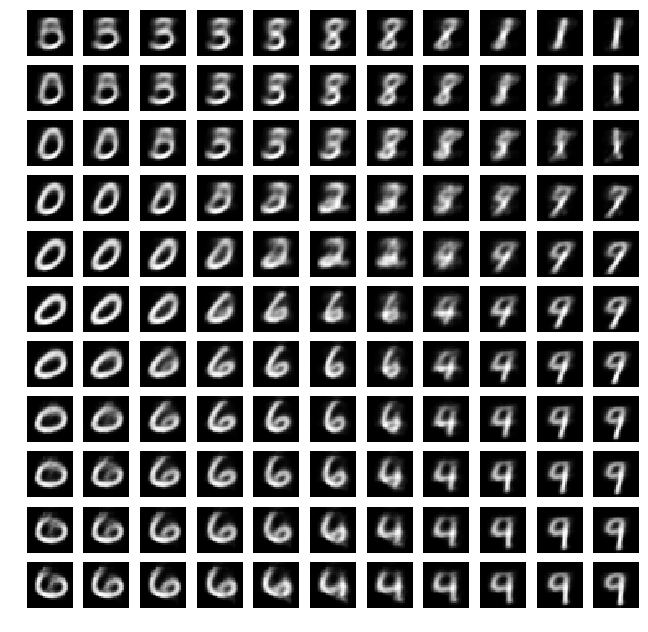

CPU times: user 6h 52min 15s, sys: 5min 23s, total: 6h 57min 38s
Wall time: 1h 2min 6s


In [17]:
%%time
EPOCHS = 100
train(train_dataset, EPOCHS)

In [20]:
def generate_and_show_images(model, arr_numbers):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = decoder(arr_numbers, training=False)

    fig = plt.figure(figsize=(11,11))

    for i in range(predictions.shape[0]):
        plt.subplot(11, 11, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

In [19]:
arr = list(np.logspace(-3, 1, num=5, base = 2))[::-1] + [0] + list(np.logspace(-3, 1, num=5, base = 2))
values = []
for i in range(121):
    values.append([arr[i%11],arr[i//11]])
num_grid2 = np.array(values).astype('float32')

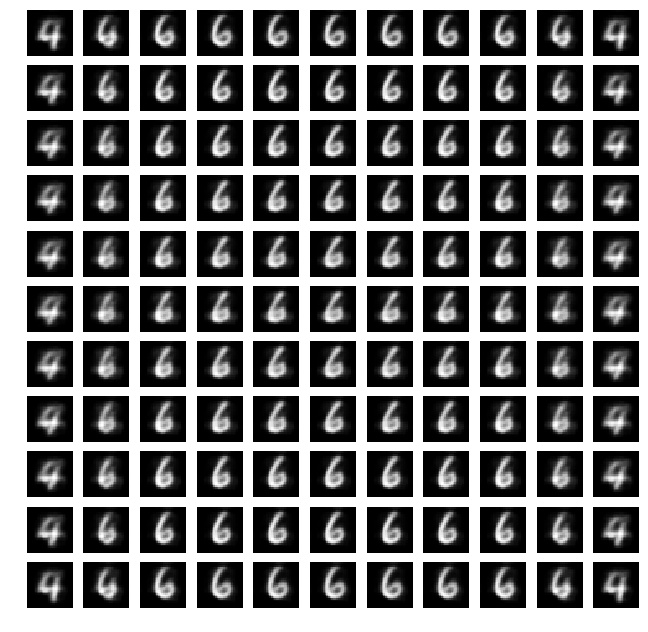

In [21]:
generate_and_show_images(decoder, num_grid2)

In [22]:
anim_file = 'VAE.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('VAE_images/image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    for _ in range(100):
        frame = 100*(i**0.5)
        if round(frame) > round(last):
          last = frame
        else:
          continue
        image = imageio.imread(filename)
        writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)